#**LAB-02 REDES CONVOLUCIONALES TRANSFER LEARNING**

##Nombre: Quispe Sucullani Jose David
##CU: 111-376
##Dirección de GitHub:

##CONTEXTO DEL LABORATORIO

Elaborar:

2.Realizar lo solicitado en el punto 1, pero utilizando un modelo preentrenado y aplicando técnicas de transfer learning y fine tunning. El modelo preentrenado no debe tener una antiguedad mayor a 5 años.

Se debe elaborar un informe en relación a los resultados que se obtengan en cada parte del trabajo.

El cuadernillo a presentar solo debe tener información que el estudiante considere necesaria.

Se debe subir el cuadernillo a ecampus y a su repositorio, para lo cual se debe incluir la dirección del mismo.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Comprobar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#1. Preparación del Dataset

In [29]:
# Definir las transformaciones para las imágenes
transformaciones = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar usando los valores de los modelos preentrenados
])

In [30]:
# CARGAR LOS DATASET

# CARGAMOS LOS DATASET DE ENTRENAMIENTO Y PRUEBA

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import os


# Cargar datasets
train_dir = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/train'
test_dir = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/test'

trainset = ImageFolder(train_dir, transform=transformaciones)
testset = ImageFolder(test_dir, transform=transformaciones)


print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
print("Número de ejemplos en el conjunto de prueba:", len(testset))

Número de ejemplos en el conjunto de entrenamiento: 4015
Número de ejemplos en el conjunto de prueba: 4009


In [31]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

In [32]:
!pip install timm # install the missing module

In [33]:
import torch
import torch.nn as nn
import timm

class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=True, freeze=False):
        super().__init__()
        # Descargar el modelo ResNeSt pretrainado
        resnest = timm.create_model('resnest50d', pretrained=pretrained)

        # Replace the classifier layer
        num_ftrs = resnest.fc.in_features
        resnest.fc = torch.nn.Linear(num_ftrs, n_outputs)

        self.resnest = resnest

        if freeze:
            for param in self.resnest.parameters():
                param.requires_grad = False
            # Ensure the new classifier layer is trainable even if freeze is True
            for param in self.resnest.fc.parameters():
                param.requires_grad = True


    def forward(self, x):
        x = self.resnest(x)
        return x

    def unfreeze(self):
        for param in self.resnest.parameters():
            param.requires_grad = True

In [34]:
# Inicializar el modelo con ResNeSt
model = ModelCustom(n_outputs=5, pretrained=True, freeze=False)

# Ver la arquitectura del modelo
print(model)

ModelCustom(
  (resnest): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

## Cargar el modelo ResNeSt preentrenado

Aquí cargamos el modelo ResNet preentrenado y lo adaptamos para la clasificación de nuestras 5 clases de materiales organicos e inorganicos

In [35]:
import timm

# Cargar el modelo ResNeSt preentrenado
resnest = timm.create_model('resnest50d', pretrained=True)

# Ver la arquitectura del modelo
print(resnest)


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (con

# Cargar el modelo preentrenado ResNeSt

In [36]:
import torch
import torch.nn as nn
import timm

# Configurar el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el modelo preentrenado ResNeSt
modelo = timm.create_model('resnest50d', pretrained=True)

# Congelar las capas del modelo para evitar su entrenamiento inicial (Transfer Learning)
for param in modelo.parameters():
    param.requires_grad = False

# Reemplazar la última capa completamente conectada para que coincida con nuestro número de clases
num_ftrs = modelo.num_features  # Obtener el número de características de la última capa
modelo.fc = nn.Linear(num_ftrs, 5)  # 5 clases de materiales

# Mover el modelo al dispositivo adecuado
modelo = modelo.to(device)


##Definir la función de pérdida y el optimizador

Aplicaremos la técnica de Fine Tuning, por lo que seleccionamos un optimizador que ajustará solo los parámetros de la última capa.

In [37]:
# Definir la función de pérdida y el optimizador
criterio = nn.CrossEntropyLoss()
optimizador = optim.AdamW(modelo.parameters(), lr=0.001, weight_decay=0.01)


##Entrenamiento del modelo

El proceso de entrenamiento incluye la fase de Transfer Learning seguida de Fine Tuning. Primero, entrenaremos solo la última capa y luego desbloquearemos algunas capas adicionales para ajustar todo el modelo.

In [38]:
# Cargar el modelo preentrenado ResNeSt
modelo = timm.create_model('resnest50d', pretrained=True)

# Congelar las capas del modelo para evitar su entrenamiento inicial (Transfer Learning)
for param in modelo.parameters():
    param.requires_grad = False

# Reemplazar la última capa completamente conectada para que coincida con nuestro número de clases
num_ftrs = modelo.num_features  # Obtener el número de características de la última capa
modelo.fc = nn.Linear(num_ftrs, 5)  # 5 clases de materiales
# Mover el modelo al dispositivo adecuado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo = modelo.to(device)


In [39]:
# Función de entrenamiento
import os
def entrenar_modelo(modelo, criterion, optimizer, epochs=10, num_checkpoint=5):
    for epoch in range(epochs):
        modelo.train()
        running_loss = 0.0

        for inputs, labels in tqdm(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = modelo(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Pérdida: {epoch_loss:.4f}")

        # Guardar el checkpoint cada num_checkpoint epochs
        if (epoch + 1) % num_checkpoint == 0:
            checkpoint_dir = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2'
            os.makedirs(checkpoint_dir, exist_ok=True) # Create directory if it doesn't exist
            checkpoint_path = f'{checkpoint_dir}/checkpoint_resnest_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': modelo.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)
            print(f'Checkpoint saved to {checkpoint_path}')

In [40]:
# Transfer Learning: Entrenar solo la última capa
entrenar_modelo(modelo, criterio, optimizador, epochs=5, num_checkpoint=2)

# Guardar el modelo completo después del entrenamiento de Transfer Learning
modelo_completo_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/modelo_transfer_learning.pth'
torch.save(modelo.state_dict(), modelo_completo_path)
print(f'Modelo entrenado guardado en {modelo_completo_path}')

100%|██████████| 63/63 [00:46<00:00,  1.35it/s]


Epoch 1/5, Pérdida: 1.6786


100%|██████████| 63/63 [00:37<00:00,  1.68it/s]


Epoch 2/5, Pérdida: 1.6825
Checkpoint saved to /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/checkpoint_resnest_2.pth


100%|██████████| 63/63 [00:40<00:00,  1.57it/s]


Epoch 3/5, Pérdida: 1.6805


100%|██████████| 63/63 [00:35<00:00,  1.75it/s]


Epoch 4/5, Pérdida: 1.6818
Checkpoint saved to /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/checkpoint_resnest_4.pth


100%|██████████| 63/63 [00:36<00:00,  1.71it/s]


Epoch 5/5, Pérdida: 1.6842
Modelo entrenado guardado en /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/modelo_transfer_learning.pth


##**FINE TUNING**

El fine tinig es para descongelas algunas capas para entrenar con todo el modelo.

In [41]:
# Desbloquear todas las capas para Fine Tuning
for param in modelo.parameters():
    param.requires_grad = True

# Definir el optimizador para Fine Tuning
optimizador = optim.AdamW(modelo.parameters(), lr=0.0001, weight_decay=0.01)

# Reentrenar con Fine Tuning
entrenar_modelo(modelo, criterio, optimizador, epochs=10, num_checkpoint=5)

# Guardar el modelo completo después del Fine Tuning
modelo_completo_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/modelo_fine_tuned.pth'
torch.save(modelo.state_dict(), modelo_completo_path)
print(f'Modelo fine-tuned guardado en {modelo_completo_path}')

100%|██████████| 63/63 [00:54<00:00,  1.16it/s]


Epoch 1/10, Pérdida: 0.0746


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 2/10, Pérdida: 0.0001


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 3/10, Pérdida: 0.0001


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 4/10, Pérdida: 0.0000


100%|██████████| 63/63 [00:53<00:00,  1.17it/s]


Epoch 5/10, Pérdida: 0.0001
Checkpoint saved to /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/checkpoint_resnest_5.pth


100%|██████████| 63/63 [00:58<00:00,  1.08it/s]


Epoch 6/10, Pérdida: 0.0000


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 7/10, Pérdida: 0.0000


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 8/10, Pérdida: 0.0000


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Epoch 9/10, Pérdida: 0.0000


100%|██████████| 63/63 [00:54<00:00,  1.17it/s]


Epoch 10/10, Pérdida: 0.0000
Checkpoint saved to /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/checkpoint_resnest_10.pth
Modelo fine-tuned guardado en /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/modelo_fine_tuned.pth


##CARGAMOS LOS MODELOS ENTRENADOS.

In [42]:
import torch
import torch.nn as nn
import copy

# Assuming 'modelo' is the original ResNet model architecture
modelo_transf_lear = copy.deepcopy(modelo)  # Create a new instance of the model
modelo_transf_lear.load_state_dict(torch.load('/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/modelo_transfer_learning.pth'))
modelo_transf_lear.eval()  # Now you can call eval() on the new model instance

# Use modelo_transf_lear for further operations

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (con

##Evaluar el modelo

In [43]:
def evaluar_modelo(modelo):
    modelo.eval()
    correctos = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicciones = torch.max(outputs, 1)
            total += labels.size(0)
            correctos += (predicciones == labels).sum().item()

    precision = 100 * correctos / total
    print(f"Precisión en el conjunto de prueba: {precision:.2f}%")

evaluar_modelo(modelo_transf_lear)


Precisión en el conjunto de prueba: 22.10%


##PRUEBAS CON UNA IMAGEN FOTOGRÁFICA

In [44]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir las transformaciones para las imágenes (debe coincidir con las del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Reducir el tamaño de la imagen a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])


In [45]:
# Función para hacer predicciones
def predict_image(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Mover el tensor de la imagen al mismo dispositivo que el modelo
    image_tensor = image_tensor.to(modelo_transf_lear.fc.weight.device)

    # Realizar la predicción
    with torch.no_grad():
        outputs = modelo_transf_lear(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

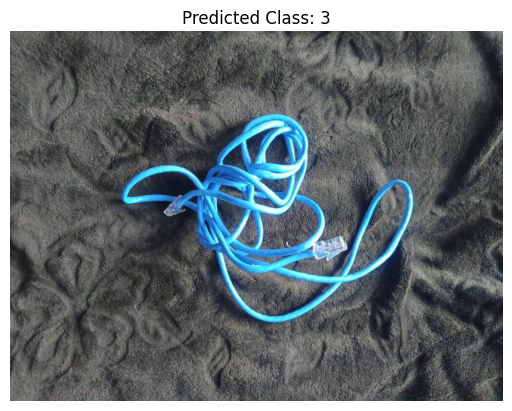

In [46]:
# Ruta de la imagen a probar
# image_path = ''  # Cambia esto a la ruta de tu imagen
# image_path = ''
# image_path = ''
# image_path = ''
image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/train/Cable-De-Red/imagen_6000.jpg'

# Obtener la clase predicha
predicted_class = predict_image(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

In [47]:
# OTRAS MANERA DE PREDECIR EL MODELO

# Cargar la imagen para prueba
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch
    return image

# Realizar una prueba con una imagen cargada
def predict(image_path):
    image = load_image(image_path)
    # Mover el tensor de la imagen al mismo dispositivo que el modelo
    image = image.to(device)
    with torch.no_grad():
        outputs = modelo_transf_lear(image)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item()

# Ejemplo de uso
image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/train/Bolsas-Soda/imagen_2868.jpg'
predicted_class = predict(image_path)
print(f'Predicted class: {predicted_class}')

Predicted class: 3


##PROBANDO OTRAS MANERA DE ENTRENAMIENTO DEL MODELO CON TRANSFER LEARNING

##Transfer Learning

In [48]:
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn as nn
import os

def fit(model, dataloader_train, dataloader_test, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader_train)
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        bar = tqdm(dataloader_test)
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        avg_train_loss = np.mean(train_loss)
        avg_train_acc = np.mean(train_acc)
        avg_val_loss = np.mean(val_loss)
        avg_val_acc = np.mean(val_acc)

        print(f"Epoch {epoch}/{epochs} loss {avg_train_loss:.5f} val_loss {avg_val_loss:.5f} acc {avg_train_acc:.5f} val_acc {avg_val_acc:.5f}")

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)

    # Guardar el modelo completo al final del entrenamiento
    checkpoint_dir = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2'
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.pth')
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_val_loss,
    }, checkpoint_path)
    print(f'Modelo completo guardado en {checkpoint_path}')
    return history

In [49]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, trainloader, testloader)

val_loss 0.46457 val_acc 0.85491: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


Epoch 1/5 loss 0.32917 val_loss 0.46457 acc 0.96776 val_acc 0.85491


val_loss 0.41631 val_acc 0.85094: 100%|██████████| 63/63 [00:35<00:00,  1.77it/s]


Epoch 2/5 loss 0.06756 val_loss 0.41631 acc 0.99950 val_acc 0.85094


val_loss 0.38929 val_acc 0.85466: 100%|██████████| 63/63 [00:37<00:00,  1.70it/s]


Epoch 3/5 loss 0.04107 val_loss 0.38929 acc 1.00000 val_acc 0.85466


val_loss 0.37190 val_acc 0.85615: 100%|██████████| 63/63 [00:36<00:00,  1.70it/s]


Epoch 4/5 loss 0.02938 val_loss 0.37190 acc 1.00000 val_acc 0.85615


val_loss 0.36772 val_acc 0.85590: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


Epoch 5/5 loss 0.02287 val_loss 0.36772 acc 1.00000 val_acc 0.85590
Modelo completo guardado en /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/model_checkpoint.pth


{'train_loss': [np.float64(0.3291665241122246),
  np.float64(0.06756437173674977),
  np.float64(0.041067821018043016),
  np.float64(0.029381827466071597),
  np.float64(0.02286891686537909)],
 'train_acc': [np.float64(0.9677579365079365),
  np.float64(0.9995039682539683),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0)],
 'val_loss': [np.float64(0.46457208326411625),
  np.float64(0.41630635623420986),
  np.float64(0.3892851384090526),
  np.float64(0.3718970043082086),
  np.float64(0.3677227720026932)],
 'val_acc': [np.float64(0.8549107142857143),
  np.float64(0.8509424603174603),
  np.float64(0.8546626984126984),
  np.float64(0.8561507936507936),
  np.float64(0.8559027777777778)]}

##Fine Runing

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en resnet, entrenamos también la red completa.

In [50]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, trainloader, testloader)

val_loss 0.19775 val_acc 0.94444: 100%|██████████| 63/63 [00:36<00:00,  1.75it/s]


Epoch 1/5 loss 0.16186 val_loss 0.19775 acc 0.97445 val_acc 0.94444


val_loss 0.15604 val_acc 0.95337: 100%|██████████| 63/63 [00:35<00:00,  1.78it/s]


Epoch 2/5 loss 0.00757 val_loss 0.15604 acc 1.00000 val_acc 0.95337


val_loss 0.15990 val_acc 0.94792: 100%|██████████| 63/63 [00:36<00:00,  1.72it/s]


Epoch 3/5 loss 0.00446 val_loss 0.15990 acc 1.00000 val_acc 0.94792


val_loss 0.15824 val_acc 0.94122: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]


Epoch 4/5 loss 0.00292 val_loss 0.15824 acc 0.99975 val_acc 0.94122


val_loss 0.12851 val_acc 0.96081: 100%|██████████| 63/63 [00:35<00:00,  1.75it/s]


Epoch 5/5 loss 0.00175 val_loss 0.12851 acc 1.00000 val_acc 0.96081
Modelo completo guardado en /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/model_checkpoint.pth


{'train_loss': [np.float64(0.16185850512591146),
  np.float64(0.007574351999672159),
  np.float64(0.004460374573393474),
  np.float64(0.0029203914159480187),
  np.float64(0.0017463860447548094)],
 'train_acc': [np.float64(0.9744543650793651),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(0.9997519841269841),
  np.float64(1.0)],
 'val_loss': [np.float64(0.19774930831044912),
  np.float64(0.15604476731580993),
  np.float64(0.15990430363527838),
  np.float64(0.15824067722710353),
  np.float64(0.12850988191729856)],
 'val_acc': [np.float64(0.9444444444444444),
  np.float64(0.9533730158730159),
  np.float64(0.9479166666666666),
  np.float64(0.9412202380952381),
  np.float64(0.9608134920634921)]}

Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un learning rate más pequeño).

In [51]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, trainloader, testloader)
model_o.unfreeze()
fit(model_o, trainloader, testloader, lr=1e-4)

val_loss 0.43077 val_acc 0.88963: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]


Epoch 1/5 loss 0.33855 val_loss 0.43077 acc 0.96503 val_acc 0.88963


val_loss 0.37365 val_acc 0.87550: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


Epoch 2/5 loss 0.06618 val_loss 0.37365 acc 1.00000 val_acc 0.87550


val_loss 0.34139 val_acc 0.88170: 100%|██████████| 63/63 [00:34<00:00,  1.80it/s]


Epoch 3/5 loss 0.04202 val_loss 0.34139 acc 0.99975 val_acc 0.88170


val_loss 0.32302 val_acc 0.88641: 100%|██████████| 63/63 [00:35<00:00,  1.79it/s]


Epoch 4/5 loss 0.02903 val_loss 0.32302 acc 1.00000 val_acc 0.88641


val_loss 0.31262 val_acc 0.88244: 100%|██████████| 63/63 [00:36<00:00,  1.73it/s]


Epoch 5/5 loss 0.02327 val_loss 0.31262 acc 1.00000 val_acc 0.88244
Modelo completo guardado en /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/model_checkpoint.pth


val_loss 0.32039 val_acc 0.88070: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]


Epoch 1/5 loss 0.02013 val_loss 0.32039 acc 1.00000 val_acc 0.88070


val_loss 0.31205 val_acc 0.88517: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]


Epoch 2/5 loss 0.01898 val_loss 0.31205 acc 1.00000 val_acc 0.88517


val_loss 0.29885 val_acc 0.88765: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]


Epoch 3/5 loss 0.01917 val_loss 0.29885 acc 0.99975 val_acc 0.88765


val_loss 0.31317 val_acc 0.88492: 100%|██████████| 63/63 [00:35<00:00,  1.76it/s]


Epoch 4/5 loss 0.01939 val_loss 0.31317 acc 1.00000 val_acc 0.88492


val_loss 0.30745 val_acc 0.88442: 100%|██████████| 63/63 [00:36<00:00,  1.71it/s]


Epoch 5/5 loss 0.01770 val_loss 0.30745 acc 1.00000 val_acc 0.88442
Modelo completo guardado en /content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/model_checkpoint.pth


{'train_loss': [np.float64(0.020132341821278845),
  np.float64(0.018980140265609537),
  np.float64(0.01916961336419696),
  np.float64(0.019388711553007837),
  np.float64(0.017702662519046237)],
 'train_acc': [np.float64(1.0),
  np.float64(1.0),
  np.float64(0.9997519841269841),
  np.float64(1.0),
  np.float64(1.0)],
 'val_loss': [np.float64(0.3203868760564734),
  np.float64(0.3120517362470901),
  np.float64(0.2988467789033339),
  np.float64(0.31317475829864777),
  np.float64(0.3074504598265603)],
 'val_acc': [np.float64(0.8807043650793651),
  np.float64(0.8851686507936508),
  np.float64(0.8876488095238095),
  np.float64(0.8849206349206349),
  np.float64(0.8844246031746031)]}

Cargamos el modelo entrenado

In [53]:
import torch
import torch.nn as nn
import copy

# Assuming 'modelo' is the original ResNet model architecture
model_transf_lear2 = copy.deepcopy(modelo)  # Create a new instance of the model
# Load the state dictionary directly
model_transf_lear2.load_state_dict(torch.load('/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/modelo_transfer_learning.pth'))
model_transf_lear2.eval()

# Use model_transf_lear2 for further operations

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (con

##Evaluación del modelo.

In [54]:
def evaluar_modelo(modelo):
    modelo.eval()
    correctos = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicciones = torch.max(outputs, 1)
            total += labels.size(0)
            correctos += (predicciones == labels).sum().item()

    precision = 100 * correctos / total
    print(f"Precisión en el conjunto de prueba: {precision:.2f}%")

evaluar_modelo(model_transf_lear2)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Precisión en el conjunto de prueba: 22.10%


In [58]:
# Función para hacer predicciones
def predict_image2(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Mover el tensor de la imagen al mismo dispositivo que el modelo
    image_tensor = image_tensor.to(model_transf_lear2.fc.weight.device)

    # Realizar la predicción
    with torch.no_grad():
        outputs = model_transf_lear2(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

##Hacemos pruebas con imagenes fotograficas del datasets creado con residuos organicos e inorganicos

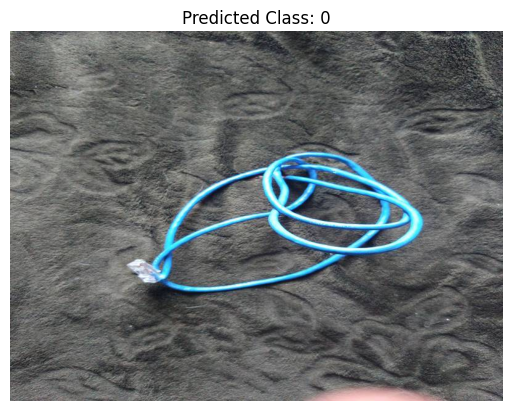

In [59]:
# Ruta de la imagen a probar
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Cambia esto a la ruta de tu imagen
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/cebolla_00386.jpg'
image_path = '/content/drive/MyDrive/Inteligencia-Artificial_2/Laboratorios/Laboratorio_2/Dataset/train/Cable-De-Red/imagen_6003.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/toronjil_00022.jpg'

# Obtener la clase predicha
predicted_class = predict_image2(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

##DETALLES

- Transfer Learning: Se ha aplicado al congelar las capas iniciales del modelo preentrenado ResNet y solo entrenar la última capa completamente conectada.

- Fine Tuning: Se ha realizado desbloqueando las capas adicionales del modelo y ajustándolas mediante el optimizador.

- Regularización y Buenas Prácticas: Se han aplicado técnicas como la normalización de imágenes, optimización con SGD y el uso de DataLoader para una carga eficiente de datos.